In [1]:
import random
import itertools
import rdkit.Chem.AllChem as Chem
from rdkit.Chem.Descriptors import ExactMolWt
import pandas as pd
import matplotlib.pyplot as plt
import dreams.utils.mols as mu
import dreams.utils.spectra as su
import dreams.utils.io as io
from pandarallel import pandarallel
from tqdm import tqdm
tqdm.pandas()
from dreams.utils.plots import init_plotting
from dreams.definitions import *
%load_ext autoreload
%autoreload 2

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [2]:
pandarallel.initialize(progress_bar=True, use_memory_fs=False, nb_workers=5)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Read and preprocess a dataset

In [2]:
# DATASET_PATH = MONA_PKL
DATASET_PATH = MERGED_DATASETS / 'MoNA_A_Murcko_split.pkl'
# DATASET_PATH = MERGED_DATASETS / 'NIST20_MoNA_A_Murcko_split.pkl'
# DATASET_PATH = NIST20 / 'nist20_clean_spec_entropy_[M+H]+_retrieval.pkl'
# DATASET_PATH = NIST20 / 'nist20_clean.pkl'

In [4]:
df = pd.read_pickle(DATASET_PATH)

# assign split colimn if not present
# if 'val' not in df.columns:
#     df['val'] = True

# Filter adducts
# df = df[df['PRECURSOR TYPE'] == '[M+H]+']

df = df.reset_index(drop=True).reset_index()
# df['index'] = df.index

# Preprocess
df['EXACT MASS'] = df['ROMol'].progress_apply(Chem.CalcExactMolWt)
df['inchi14'] = df['ROMol'].progress_apply(mu.mol_to_inchi14)
# df = df.reset_index(drop=True).reset_index()

df

100%|██████████| 28876/28876 [00:03<00:00, 8790.81it/s]


,index,ID,PARSED PEAKS,SMILES,PRECURSOR M/Z,FORMULA,CHARGE,ROMol,COLLISION ENERGY,ION MODE,PRECURSOR TYPE,INSTRUMENT TYPE,INSTRUMENT,MSnSpectrum,inchi14,MurckoHist,MurckoHistStr,val,EXACT MASS
0,0,MoNA_56916_Anabasine,"[[39.2, 41.2, 42.3, 43.0, 44.1, 44.6, 45.9, 51...",c1cncc([C@@H]2CCCCN2)c1,163.00000,C10H14N2,1,<rdkit.Chem.rdchem.Mol object at 0x297b03360>,50 V,P,[M+H]+,LC-ESI-QQ,"API3000, Applied Biosystems",<msml.utils.spectra.MSnSpectrum object at 0x29...,MTXSIJUGVMTTMU,{'0_1': 2},{'0_1': 2},False,162.115698
1,1,MoNA_50514_Erythromycin,"[[83.0498, 98.0969, 113.06, 115.0757, 116.071,...",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,734.46850,C37H67NO13,1,<rdkit.Chem.rdchem.Mol object at 0x297b03310>,NCE 20%,P,[M+H]+,nan,Thermo Q Exactive HF,<msml.utils.spectra.MSnSpectrum object at 0x29...,ULGZDMOVFRHVEP,"{'0_1': 2, '0_2': 1}","{'0_1': 2, '0_2': 1}",True,733.461241
2,2,MoNA_29825_Gabapentin-lactam,"[[54.0337, 55.0541, 60.0442, 65.0385, 67.0542,...",OC1=NCC2(CCCCC2)C1,154.12260,C9H15NO,1,<rdkit.Chem.rdchem.Mol object at 0x297b03400>,90 % (nominal),P,[M+H]+,LC-ESI-ITFT,LTQ Orbitrap XL Thermo Scientific,<msml.utils.spectra.MSnSpectrum object at 0x29...,JAWPQJDOQPSNIQ,{'0_0': 2},{'0_0': 2},True,153.115364
3,3,"MoNA_75706_5-chloro-2,4-dihydroxy-6-methyl-3-[...","[[50.738331, 57.461353, 59.049854, 61.929092, ...",CC(/C=C/[C@@]1(C)[C@H](C)CCC(=O)[C@@H]1C)=C\Cc...,405.16900,C23H29ClO4,1,<rdkit.Chem.rdchem.Mol object at 0x297b03450>,NaN,P,[M+H]+,nan,Orbitrap,<msml.utils.spectra.MSnSpectrum object at 0x29...,SETVRSKZJJWOPA,{'0_1': 2},{'0_1': 2},False,404.175437
4,4,MoNA_42026_Senkirkine,"[[70.0651, 81.0698, 83.0492, 94.0652, 101.0598...",C/C=C1/C[C@@H](C)[C@@](C)(O)C(=O)OC/C2=C/CN(C)...,366.19110,C19H27NO6,1,<rdkit.Chem.rdchem.Mol object at 0x297b034a0>,40 % (nominal),P,[M+H]+,LC-ESI-ITFT,LTQ Orbitrap XL Thermo Scientific,<msml.utils.spectra.MSnSpectrum object at 0x29...,HPDHKHMHQGCNPE,{'0_0': 1},{'0_0': 1},False,365.183838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28871,28871,MoNA_38998_Gelsemine,"[[70.0651, 79.0541, 86.0602, 91.0542, 94.0654,...",C=C[C@]12CN(C)[C@@H]3[C@H]4COC(CC41)[C@]1(C(O)...,323.17540,C20H22N2O2,1,<rdkit.Chem.rdchem.Mol object at 0x29e9569a0>,95% (nominal),P,[M+H]+,LC-ESI-ITFT,LTQ Orbitrap XL Thermo Scientific,<msml.utils.spectra.MSnSpectrum object at 0x2a...,NFYYATWFXNPTRM,"{'1_0': 2, '7_0': 1, '9_0': 1, '10_0': 2}","{'1_0': 2, '7_0': 1, '9_0': 1, '10_0': 2}",False,322.168128
28872,28872,MoNA_45707_MEVALONOLACTONE,"[[41.03981, 43.01888, 43.04405, 43.05473, 53.0...",C[C@]1(O)CCOC(=O)C1,131.07027,C6H10O3,1,<rdkit.Chem.rdchem.Mol object at 0x29e9569f0>,10 eV,P,[M+H]+,LC-ESI-QTOF,Agilent qTOF 6545,<msml.utils.spectra.MSnSpectrum object at 0x2a...,JYVXNLLUYHCIIH,{'0_0': 1},{'0_0': 1},False,130.062994
28873,28873,MoNA_86187_Phenylbenzimidazole sulfonic acid,"[[139.0549, 140.0583, 154.0636, 166.0638, 167....",O=S(=O)(O)c1ccc2nc(-c3ccccc3)[nH]c2c1,275.04850,C13H10N2O3S,1,<rdkit.Chem.rdchem.Mol object at 0x29e956a40>,50 eV,P,[M+H]+,LC-ESI-QTOF,Bruker maXis Impact,<msml.utils.spectra.MSnSpectrum object at 0x2a...,UVCJGUGAGLDPAA,"{'0_1': 1, '1_0': 1, '1_1': 1}","{'0_1': 1, '1_0': 1, '1_1': 1}",False,274.041213
28874,28874,MoNA_52548_1-Amino-2-methylanthraquinone,"[[53.0387, 65.0385, 72.0444, 77.0386, 79.0543,...",Cc1ccc2c(c1N)C(=O)c1ccccc1C2=O,238.08630,C15H11NO2,1,<rdkit.Chem.rdchem.Mol object at 0x29e956a90>,90,P,[M+H]+,LC-ESI-QFT,Q Exactive Orbitrap (Thermo Scientific),<msml.utils.spectra.MSnSpectrum object at 0x2a...,ZLCUIOWQYBYEBG,"{'1_0': 2, '2_0': 1}","{'1_0': 2, '2_0': 1}",True,237.078979


In [5]:
df['val'].value_counts()

False    25319
True      3557
Name: val, dtype: int64

In [6]:
df['PRECURSOR TYPE'].value_counts()

[M+H]+        25903
[M+NH4]+       1348
[M+Na]+        1244
[M-H2O+H]+      334
[M+K]+           47
Name: PRECURSOR TYPE, dtype: int64

## Positive examples: Spectra of the same compound by the first InChI 14 characters

Has neighbours True     23920
False     1983
Name: Num. of inchi14 neighbours, dtype: int64


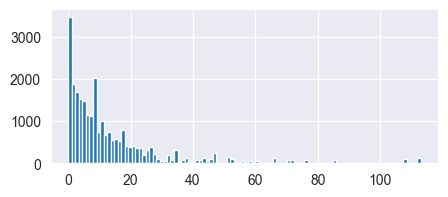

is_val True
Has neighbours True     2722
False     270
Name: Num. of inchi14 neighbours, dtype: int64


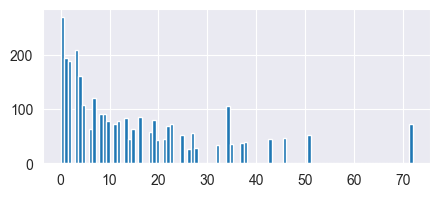

is_val False
Has neighbours True     21198
False     1713
Name: Num. of inchi14 neighbours, dtype: int64


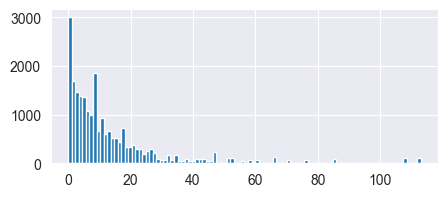

In [13]:
# Get inchi neighbours
def get_inchi_neighbours(row):
    return df[(df['inchi14'] == row['inchi14']) & (df['index'] != row['index']) & (df['val'] == row['val'])].index.tolist()
df['inchi14 neighbours'] = df.parallel_apply(get_inchi_neighbours, axis=1)
df['Num. of inchi14 neighbours'] = df['inchi14 neighbours'].apply(len)

# Analyse distribution of number of inchi neighbours in the whole dataset
print('Has neighbours', (df['Num. of inchi14 neighbours'] > 0).value_counts())
df['Num. of inchi14 neighbours'].hist(bins=100, figsize=(5, 2))
plt.show()

# Analyse distribution of number of inchi neighbours across folds
for is_val in [True, False]:
    print('is_val', is_val)
    df_is_val = df[df['val'] == is_val]
    print('Has neighbours', (df_is_val['Num. of inchi14 neighbours'] > 0).value_counts())
    df_is_val['Num. of inchi14 neighbours'].hist(bins=100, figsize=(5, 2))
    plt.show()

In [14]:
print(len(df))
print((df['Num. of inchi14 neighbours'] > 0).sum())
# df = df[df['Num. of inchi14 neighbours'] > 0].copy()
# print(len(df))

25903
23920


## Negative examples: Spectra of a different compound within defined mass neighbourhood

Has neighbours True     23049
False     2854
Name: Num. of mass tolerance neighbours, dtype: int64


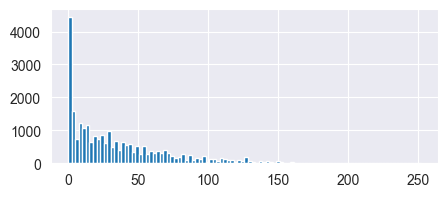

is_val True
Has neighbours True     1988
False    1004
Name: Num. of mass tolerance neighbours, dtype: int64
top-5 value_counts Num. of mass tolerance neighbours
0    1004
1     306
2     152
6     105
4     104
dtype: int64


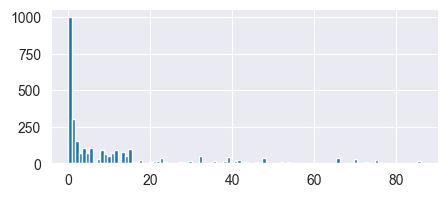

is_val False
Has neighbours True     21061
False     1850
Name: Num. of mass tolerance neighbours, dtype: int64
top-5 value_counts Num. of mass tolerance neighbours
0     1850
1      681
4      533
11     484
2      459
dtype: int64


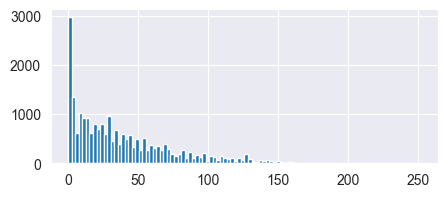

In [17]:
def get_neg_neighbours(row, ppm_delta=None, da_delta=0.05):
    m = row['EXACT MASS']
    inchi = row['inchi14']

    assert da_delta is not None or ppm_delta is not None
    assert da_delta is None or ppm_delta is None
    if da_delta is not None:
        mass_tolerance = da_delta
    else:
        mass_tolerance = m * 1e-6 * ppm_delta
    
    return df[
        ((df['EXACT MASS'] - m).abs() <= mass_tolerance) &
        (df['inchi14'] != inchi) & 
        (df['val'] == row['val'])
    ].index.tolist()

# Analyse distribution of number of negative neighbours in the whole dataset
df[f'Mass tolerance neighbours'] = df.parallel_apply(get_neg_neighbours, axis=1)
df[f'Num. of mass tolerance neighbours'] = df[f'Mass tolerance neighbours'].apply(len)
print('Has neighbours', (df[f'Num. of mass tolerance neighbours'] > 0).value_counts())
df[f'Num. of mass tolerance neighbours'].hist(bins=100, figsize=(5, 2))
plt.show()

# Analyse distribution of number of negative neighbours across folds
for is_val in [True, False]:
    print('is_val', is_val)
    df_is_val = df[df['val'] == is_val]
    print('Has neighbours', (df_is_val[f'Num. of mass tolerance neighbours'] > 0).value_counts())
    print('top-5 value_counts', df_is_val.value_counts('Num. of mass tolerance neighbours').head(5))
    df_is_val[f'Num. of mass tolerance neighbours'].hist(bins=100, figsize=(5, 2))
    plt.show()

In [19]:
print(len(df))
print((df[f'Num. of mass tolerance neighbours'] > 0).sum())
# df = df[df[f'Num. of mass tolerance neighbours'] > 0].copy()
# len(df)

25903
23049


In [20]:
print(df['Num. of inchi14 neighbours'].sum())
print(df['Num. of mass tolerance neighbours'].sum())
print(df['Num. of inchi14 neighbours'].sum() + df['Num. of mass tolerance neighbours'].sum())

349552
897512
1247064


## Save the dataset with neighbors (positive and negative examples)

In [25]:
df = su.df_to_MSnSpectra(df, assert_is_valid=False, as_new_column=True).copy()
df = df.rename(columns={'inchi14 neighbours': 'pos_idx', f'Mass tolerance neighbours': 'neg_idx'})
df = df.drop(columns=['Num. of inchi14 neighbours', f'Num. of mass tolerance neighbours'])

In [26]:
df.to_pickle(io.append_to_stem(DATASET_PATH, f'neighbours_[M+H]+_0.05Da'))

In [16]:
# df = pd.read_pickle(io.append_to_stem(DATASET_PATH, f'NIST_contrastive_v2_10ppm'))

In [7]:
df['val'].value_counts()

False    25319
True      3557
Name: val, dtype: int64

In [3]:
df = pd.read_pickle(io.append_to_stem(DATASET_PATH, f'neighbours_[M+H]+_0.05Da'))
df

,index,ID,PARSED PEAKS,SMILES,PRECURSOR M/Z,FORMULA,CHARGE,ROMol,COLLISION ENERGY,ION MODE,...,INSTRUMENT TYPE,INSTRUMENT,MSnSpectrum,inchi14,MurckoHist,MurckoHistStr,val,EXACT MASS,pos_idx,neg_idx
0,0,MoNA_56916_Anabasine,"[[39.2, 41.2, 42.3, 43.0, 44.1, 44.6, 45.9, 51...",c1cncc([C@@H]2CCCCN2)c1,163.00000,C10H14N2,1,<rdkit.Chem.rdchem.Mol object at 0x2a464fe00>,50 V,P,...,LC-ESI-QQ,"API3000, Applied Biosystems",<msml.utils.spectra.MSnSpectrum object at 0x2a...,MTXSIJUGVMTTMU,{'0_1': 2},{'0_1': 2},False,162.115698,"[2490, 3862, 4310, 4391, 5598, 6314, 6525, 677...","[243, 324, 930, 1325, 1357, 1386, 1535, 1680, ..."
1,1,MoNA_50514_Erythromycin,"[[83.0498, 98.0969, 113.06, 115.0757, 116.071,...",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,734.46850,C37H67NO13,1,<rdkit.Chem.rdchem.Mol object at 0x2a464fdb0>,NCE 20%,P,...,nan,Thermo Q Exactive HF,<msml.utils.spectra.MSnSpectrum object at 0x2a...,ULGZDMOVFRHVEP,"{'0_1': 2, '0_2': 1}","{'0_1': 2, '0_2': 1}",True,733.461241,"[772, 4624, 6187, 6228, 8304, 8662, 10860, 141...","[10658, 11634]"
2,2,MoNA_29825_Gabapentin-lactam,"[[54.0337, 55.0541, 60.0442, 65.0385, 67.0542,...",OC1=NCC2(CCCCC2)C1,154.12260,C9H15NO,1,<rdkit.Chem.rdchem.Mol object at 0x2a464fea0>,90 % (nominal),P,...,LC-ESI-ITFT,LTQ Orbitrap XL Thermo Scientific,<msml.utils.spectra.MSnSpectrum object at 0x2a...,JAWPQJDOQPSNIQ,{'0_0': 2},{'0_0': 2},True,153.115364,"[2680, 6458, 6489, 6615, 6843, 8961, 10096, 10...",[]
3,3,"MoNA_75706_5-chloro-2,4-dihydroxy-6-methyl-3-[...","[[50.738331, 57.461353, 59.049854, 61.929092, ...",CC(/C=C/[C@@]1(C)[C@H](C)CCC(=O)[C@@H]1C)=C\Cc...,405.16900,C23H29ClO4,1,<rdkit.Chem.rdchem.Mol object at 0x2a464fef0>,NaN,P,...,nan,Orbitrap,<msml.utils.spectra.MSnSpectrum object at 0x2a...,SETVRSKZJJWOPA,{'0_1': 2},{'0_1': 2},False,404.175437,[3697],"[1303, 1502, 4870, 6188, 7346, 8368, 10881, 12..."
4,4,MoNA_42026_Senkirkine,"[[70.0651, 81.0698, 83.0492, 94.0652, 101.0598...",C/C=C1/C[C@@H](C)[C@@](C)(O)C(=O)OC/C2=C/CN(C)...,366.19110,C19H27NO6,1,<rdkit.Chem.rdchem.Mol object at 0x2a464ff40>,40 % (nominal),P,...,LC-ESI-ITFT,LTQ Orbitrap XL Thermo Scientific,<msml.utils.spectra.MSnSpectrum object at 0x2a...,HPDHKHMHQGCNPE,{'0_0': 1},{'0_0': 1},False,365.183838,"[1494, 2294, 3348, 3694, 5538, 6743, 8033, 823...","[34, 72, 321, 2621, 5926, 7623, 8415, 9316, 11..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25898,25898,MoNA_38998_Gelsemine,"[[70.0651, 79.0541, 86.0602, 91.0542, 94.0654,...",C=C[C@]12CN(C)[C@@H]3[C@H]4COC(CC41)[C@]1(C(O)...,323.17540,C20H22N2O2,1,<rdkit.Chem.rdchem.Mol object at 0x2aa2e0d10>,95% (nominal),P,...,LC-ESI-ITFT,LTQ Orbitrap XL Thermo Scientific,<msml.utils.spectra.MSnSpectrum object at 0x2a...,NFYYATWFXNPTRM,"{'1_0': 2, '7_0': 1, '9_0': 1, '10_0': 2}","{'1_0': 2, '7_0': 1, '9_0': 1, '10_0': 2}",False,322.168128,"[1838, 1949, 6181, 6994, 7686, 9010, 13612, 14...","[904, 1281, 1549, 1648, 1785, 2041, 3498, 3968..."
25899,25899,MoNA_45707_MEVALONOLACTONE,"[[41.03981, 43.01888, 43.04405, 43.05473, 53.0...",C[C@]1(O)CCOC(=O)C1,131.07027,C6H10O3,1,<rdkit.Chem.rdchem.Mol object at 0x2aa2e0d60>,10 eV,P,...,LC-ESI-QTOF,Agilent qTOF 6545,<msml.utils.spectra.MSnSpectrum object at 0x2a...,JYVXNLLUYHCIIH,{'0_0': 1},{'0_0': 1},False,130.062994,"[820, 1361, 2915, 4031, 5623, 10409, 13586, 16...","[506, 1980, 2232, 2483, 3076, 6341, 8347, 8404..."
25900,25900,MoNA_86187_Phenylbenzimidazole sulfonic acid,"[[139.0549, 140.0583, 154.0636, 166.0638, 167....",O=S(=O)(O)c1ccc2nc(-c3ccccc3)[nH]c2c1,275.04850,C13H10N2O3S,1,<rdkit.Chem.rdchem.Mol object at 0x2aa2e0db0>,50 eV,P,...,LC-ESI-QTOF,Bruker maXis Impact,<msml.utils.spectra.MSnSpectrum object at 0x2a...,UVCJGUGAGLDPAA,"{'0_1': 1, '1_0': 1, '1_1': 1}","{'0_1': 1, '1_0': 1, '1_1': 1}",False,274.041213,"[3572, 4525, 5193, 11287]","[257, 760, 763, 5746, 6528, 9497, 10820, 12522..."
25901,25901,MoNA_52548_1-Amino-2-methylanthraquinone,"[[53.0387, 65.0385, 72.0444, 77.0386, 79.0543,...",Cc1ccc2c(

In [5]:
df['inchi14'].nunique()

5442

# Precompute all pairwise (or just neighboring) Tanimoto similarities (for training/validation evaluation)

In [18]:
# Pre-compute Tanimoto similarity on Morgan fingerprints
def get_tanimoto_similarities_to_nieghbors(row, neighbors_col='pos_idx'):
    sims = []
    for i in row[neighbors_col]:
        sims.append(mu.morgan_smiles_sim(row['SMILES'], df.loc[i]['SMILES']))
    return sims

df['pos_tanimoto_similarities'] = df.parallel_apply(get_tanimoto_similarities_to_nieghbors, axis=1)
df['neg_tanimoto_similarities'] = df.parallel_apply(get_tanimoto_similarities_to_nieghbors, axis=1, neighbors_col='neg_idx')
df

,ID,PARSED PEAKS,SMILES,PRECURSOR M/Z,FORMULA,CHARGE,ROMol,COLLISION ENERGY,ION MODE,PRECURSOR TYPE,...,inchi14,MurckoHist,MurckoHistStr,val,EXACT MASS,index,pos_idx,neg_idx,pos_tanimoto_similarities,neg_tanimoto_similarities
11,MoNA_52001_Imazalil,"[[52.0182, 53.0022, 53.9975, 54.0101, 54.0339,...",C=CCOC(Cn1ccnc1)c1ccc(Cl)cc1Cl,297.055600,C14H14Cl2N2O,1,<rdkit.Chem.rdchem.Mol object at 0x4003c5450>,75,P,[M+H]+,...,PZBPKYOVPCNPJY,{'0_1': 2},{'0_1': 2},False,296.048318,11,"[460, 21173, 50543, 51224, 97139, 116262, 1313...","[123846, 438591]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.03571428571428571, 0.03571428571428571]"
20,MoNA_43337_RANITIDINE,"[[58.06535, 81.0336, 83.06036, 84.0685, 88.021...",CN/C(=C\[N+](=O)[O-])NCCSCc1ccc(CN(C)C)o1,315.148538,C13H22N4O3S,1,<rdkit.Chem.rdchem.Mol object at 0x4003c5180>,HCD (NCE 20-30-40%),P,[M+H]+,...,VMXUWOKSQNHOCA,{'0_0': 1},{'0_0': 1},False,314.141262,20,"[7678, 54542, 69154, 84301, 132223, 133877, 13...",[],"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[]
41,MoNA_88852_Fluvastatin,"[[123.0436, 141.0545, 212.0906, 223.0807, 224....",CC(C)n1c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c(-c2...,412.191900,C24H26FNO4,1,<rdkit.Chem.rdchem.Mol object at 0x4003bf9f0>,20 eV,P,[M+H]+,...,FJLGEFLZQAZZCD,"{'0_1': 1, '1_0': 1, '1_1': 1}","{'0_1': 1, '1_0': 1, '1_1': 1}",False,411.184587,41,"[676, 25962, 51608, 68151, 163539, 168153, 190...",[],"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[]
42,MoNA_66514_Spiramycin,"[[59.0492, 69.0334, 70.065, 71.0491, 72.0444, ...",CO[C@@H]1[C@@H](OC2OC(C)C(OC3CC(C)(O)C(O)C(C)O...,843.521300,C43H74N2O14,1,<rdkit.Chem.rdchem.Mol object at 0x4003bf9a0>,45 (nominal),P,[M+H]+,...,ACTOXUHEUCPTEW,"{'0_1': 2, '0_2': 2}","{'0_1': 2, '0_2': 2}",False,842.514005,42,"[20483, 314521, 460038]",[],"[1.0, 1.0, 1.0]",[]
81,MoNA_87362_Dimethachlor ESA,"[[132.0807, 133.0837, 146.0967, 147.1038, 148....",COCCN(C(=O)CS(=O)(=O)O)c1c(C)cccc1C,302.105700,C13H19NO5S,1,<rdkit.Chem.rdchem.Mol object at 0x4003b9b30>,Ramp 21.6-32.5 eV,P,[M+H]+,...,RVSCDWJKJDBFRS,{'0_0': 1},{'0_0': 1},False,301.098394,81,"[107582, 116167, 160407, 177003, 266080, 31742...",[],"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482861,MoNA_53418_2-Naphthylamine,"[[53.0386, 63.0229, 77.0384, 91.0542, 103.0542...",Nc1ccc2ccccc2c1,144.080800,C10H9N,1,<rdkit.Chem.rdchem.Mol object at 0x301c23540>,90,P,[M+H]+,...,JBIJLHTVPXGSAM,{'1_0': 2},{'1_0': 2},False,143.073499,482861,"[88305, 264127]",[],"[1.0, 1.0]",[]
482901,MoNA_75944_O-methylarmepavine,"[[55.018253, 58.065189, 59.068359, 72.044334, ...",COc1ccc(C[C@@H]2c3cc(OC)c(OC)cc3CCN2C)cc1,328.192000,C20H25NO3,1,<rdkit.Chem.rdchem.Mol object at 0x301c0e8b0>,NaN,P,[M+H]+,...,LZJWNVLTWYMMDJ,"{'0_1': 1, '1_0': 1, '1_1': 1}","{'0_1': 1, '1_0': 1, '1_1': 1}",False,327.183444,482901,[],[456018],[],[0.08955223880597014]
482942,MoNA_88420_Pentoxifylline,"[[110.0707, 120.0541, 121.0625, 122.0579, 123....",CC(=O)CCCCn1c(=O)c2c(ncn2C)n(C)c1=O,279.145200,C13H18N4O3,1,<rdkit.Chem.rdchem.Mol object at 0x301c00b30>,50 eV,P,[M+H]+,...,BYPFEZZEUUWMEJ,{'1_0': 2},{'1_0': 2},False,278.137890,482942,"[12568, 18314, 79920, 447820]",[72313],"[1.0, 1.0, 1.0, 1.0]",[0.6304347826086957]
482947,MoNA_30913_Benzocaine,"[[53.0388, 65.0385, 67.0542, 77.0385, 92.0494,...",CCOC(=O)c1ccc(N)cc1,166.086300,C9H11NO2,1,<rdkit.Chem.rdchem.Mol object at 0x301c009a0>,35 (nominal),P,[M+H]+,...,BLFLLBZGZJTVJG,{'0_0': 1},{'0_0': 1},False,165.078979,482947,"[65339, 95542, 96668, 199994, 206133, 222145, ...","[1697, 20000, 21008, 36342, 99375, 107021, 123...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.625, 0.2, 0.2, 0.2, 0.2, 0.625, 0.2, 0.2, 0..."


In [6]:
# Pre-compite all pairwise Tanimoto similarities
smiles = df['SMILES'].unique()
len(smiles), len(smiles) ** 2

(23104, 533794816)

In [10]:
# Complete
# df_smiles = pd.DataFrame(list(itertools.product(smiles, smiles)), columns=['SMILES 1', 'SMILES 2'])

# Only triangle
df_smiles = []
for i, smiles1 in tqdm(enumerate(smiles), total=len(smiles)):
    for j, smiles2 in enumerate(smiles):
        if i < j:
            df_smiles.append((smiles1, smiles2))

df_smiles = pd.DataFrame(df_smiles, columns=['SMILES 1', 'SMILES 2'])
df_smiles

100%|██████████| 23104/23104 [01:16<00:00, 301.30it/s]


,SMILES 1,SMILES 2
0,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(CO[P@SP](=O)(O)OC...,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...
1,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(CO[P@SP](=O)(O)OC...,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...
2,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(CO[P@SP](=O)(O)OC...,CCCCC/C=C\C/C=C\C/C=C\CCCCCCC(=O)OCC(O)CO[P@SP...
3,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(CO[P@SP](=O)(O)OC...,CCCCCCCC/C=C/C/C=C/CCCCC(=O)O[C@H](COC(=O)CCCC...
4,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(CO[P@SP](=O)(O)OC...,CCCCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCCCCC...
...,...,...
266885851,CCOc1ccc(/N=N/c2c(O)ccc3cccc(NC(=O)c4ccco4)c23...,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1OC(C...
266885852,CCOc1ccc(/N=N/c2c(O)ccc3cccc(NC(=O)c4ccco4)c23...,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...
266885853,Cc1n[nH]c(C)c1/N=N/c1sc(C(=O)O)c(C)c1C(=O)O,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1OC(C...
266885854,Cc1n[nH]c(C)c1/N=N/c1sc(C(=O)O)c(C)c1C(=O)O,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...


In [11]:
df_smiles['tanimoto_similarity'] = df_smiles.parallel_apply(lambda row: mu.morgan_smiles_sim(row['SMILES 1'], row['SMILES 2']), axis=1)
df_smiles

,SMILES 1,SMILES 2,tanimoto_similarity
0,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(CO[P@SP](=O)(O)OC...,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,0.569231
1,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(CO[P@SP](=O)(O)OC...,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,0.587302
2,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(CO[P@SP](=O)(O)OC...,CCCCC/C=C\C/C=C\C/C=C\CCCCCCC(=O)OCC(O)CO[P@SP...,0.507463
3,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(CO[P@SP](=O)(O)OC...,CCCCCCCC/C=C/C/C=C/CCCCC(=O)O[C@H](COC(=O)CCCC...,0.544118
4,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(CO[P@SP](=O)(O)OC...,CCCCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCCCCC...,0.476923
...,...,...,...
266885851,CCOc1ccc(/N=N/c2c(O)ccc3cccc(NC(=O)c4ccco4)c23...,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1OC(C...,0.075758
266885852,CCOc1ccc(/N=N/c2c(O)ccc3cccc(NC(=O)c4ccco4)c23...,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,0.101852
266885853,Cc1n[nH]c(C)c1/N=N/c1sc(C(=O)O)c(C)c1C(=O)O,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1OC(C...,0.059829
266885854,Cc1n[nH]c(C)c1/N=N/c1sc(C(=O)O)c(C)c1C(=O)O,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,0.052083


In [12]:
# Pickle
df_smiles.to_pickle(io.append_to_stem(DATASET_PATH, f'MoNA_contrastive_v2_10ppm_smiles_similarities_asymmetric'))

In [23]:
DATASET_PATH

PosixPath('/Users/anton/dev/ms/msml/msml/data/merged/datasets/NIST20_MoNA_A_Murcko_split.pkl')

# Single sample examples

In [24]:
df

,index,ID,PARSED PEAKS,SMILES,PRECURSOR M/Z,FORMULA,CHARGE,ROMol,COLLISION ENERGY,ION MODE,...,MSnSpectrum,inchi14,MurckoHist,MurckoHistStr,val,EXACT MASS,inchi14 neighbours,Num. of inchi14 neighbours,Mass tolerance neighbours,Num. of mass tolerance neighbours
0,0,MoNA_56916_Anabasine,"[[39.2, 41.2, 42.3, 43.0, 44.1, 44.6, 45.9, 51...",c1cncc([C@@H]2CCCCN2)c1,163.00000,C10H14N2,1,<rdkit.Chem.rdchem.Mol object at 0x2aba0b900>,50 V,P,...,<msml.utils.spectra.MSnSpectrum object at 0x2a...,MTXSIJUGVMTTMU,{'0_1': 2},{'0_1': 2},False,162.115698,"[2490, 3862, 4310, 4391, 5598, 6314, 6525, 677...",47,"[243, 324, 930, 1325, 1357, 1386, 1535, 1680, ...",127
1,1,MoNA_50514_Erythromycin,"[[83.0498, 98.0969, 113.06, 115.0757, 116.071,...",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,734.46850,C37H67NO13,1,<rdkit.Chem.rdchem.Mol object at 0x2aba0b8b0>,NCE 20%,P,...,<msml.utils.spectra.MSnSpectrum object at 0x2a...,ULGZDMOVFRHVEP,"{'0_1': 2, '0_2': 1}","{'0_1': 2, '0_2': 1}",True,733.461241,"[772, 4624, 6187, 6228, 8304, 8662, 10860, 141...",10,"[10658, 11634]",2
2,2,MoNA_29825_Gabapentin-lactam,"[[54.0337, 55.0541, 60.0442, 65.0385, 67.0542,...",OC1=NCC2(CCCCC2)C1,154.12260,C9H15NO,1,<rdkit.Chem.rdchem.Mol object at 0x2aba0b9a0>,90 % (nominal),P,...,<msml.utils.spectra.MSnSpectrum object at 0x2a...,JAWPQJDOQPSNIQ,{'0_0': 2},{'0_0': 2},True,153.115364,"[2680, 6458, 6489, 6615, 6843, 8961, 10096, 10...",11,[],0
3,3,"MoNA_75706_5-chloro-2,4-dihydroxy-6-methyl-3-[...","[[50.738331, 57.461353, 59.049854, 61.929092, ...",CC(/C=C/[C@@]1(C)[C@H](C)CCC(=O)[C@@H]1C)=C\Cc...,405.16900,C23H29ClO4,1,<rdkit.Chem.rdchem.Mol object at 0x2aba0b9f0>,NaN,P,...,<msml.utils.spectra.MSnSpectrum object at 0x2a...,SETVRSKZJJWOPA,{'0_1': 2},{'0_1': 2},False,404.175437,[3697],1,"[1303, 1502, 4870, 6188, 7346, 8368, 10881, 12...",14
4,4,MoNA_42026_Senkirkine,"[[70.0651, 81.0698, 83.0492, 94.0652, 101.0598...",C/C=C1/C[C@@H](C)[C@@](C)(O)C(=O)OC/C2=C/CN(C)...,366.19110,C19H27NO6,1,<rdkit.Chem.rdchem.Mol object at 0x2aba0ba40>,40 % (nominal),P,...,<msml.utils.spectra.MSnSpectrum object at 0x2a...,HPDHKHMHQGCNPE,{'0_0': 1},{'0_0': 1},False,365.183838,"[1494, 2294, 3348, 3694, 5538, 6743, 8033, 823...",34,"[34, 72, 321, 2621, 5926, 7623, 8415, 9316, 11...",14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25898,25898,MoNA_38998_Gelsemine,"[[70.0651, 79.0541, 86.0602, 91.0542, 94.0654,...",C=C[C@]12CN(C)[C@@H]3[C@H]4COC(CC41)[C@]1(C(O)...,323.17540,C20H22N2O2,1,<rdkit.Chem.rdchem.Mol object at 0x2afb1af90>,95% (nominal),P,...,<msml.utils.spectra.MSnSpectrum object at 0x2b...,NFYYATWFXNPTRM,"{'1_0': 2, '7_0': 1, '9_0': 1, '10_0': 2}","{'1_0': 2, '7_0': 1, '9_0': 1, '10_0': 2}",False,322.168128,"[1838, 1949, 6181, 6994, 7686, 9010, 13612, 14...",12,"[904, 1281, 1549, 1648, 1785, 2041, 3498, 3968...",28
25899,25899,MoNA_45707_MEVALONOLACTONE,"[[41.03981, 43.01888, 43.04405, 43.05473, 53.0...",C[C@]1(O)CCOC(=O)C1,131.07027,C6H10O3,1,<rdkit.Chem.rdchem.Mol object at 0x2afb1f040>,10 eV,P,...,<msml.utils.spectra.MSnSpectrum object at 0x2b...,JYVXNLLUYHCIIH,{'0_0': 1},{'0_0': 1},False,130.062994,"[820, 1361, 2915, 4031, 5623, 10409, 13586, 16...",10,"[506, 1980, 2232, 2483, 3076, 6341, 8347, 8404...",38
25900,25900,MoNA_86187_Phenylbenzimidazole sulfonic acid,"[[139.0549, 140.0583, 154.0636, 166.0638, 167....",O=S(=O)(O)c1ccc2nc(-c3ccccc3)[nH]c2c1,275.04850,C13H10N2O3S,1,<rdkit.Chem.rdchem.Mol object at 0x2afb1f090>,50 eV,P,...,<msml.utils.spectra.MSnSpectrum object at 0x2b...,UVCJGUGAGLDPAA,"{'0_1': 1, '1_0': 1, '1_1': 1}","{'0_1': 1, '1_0': 1, '1_1': 1}",False,274.041213,"[3572, 4525, 5193, 11287]",4,"[257, 760, 763, 5746, 6528, 9497, 10820, 12522...",20
25901,25901,MoNA_52548_1-Amino-2-methylanthraquinone,"[[53.0387, 65.0385, 72.0444, 77.0386, 79.0543,...",Cc1ccc2c(c1N)C(=O)c1ccccc1C2=O,238.08630,C15H11NO2,1,<rdkit.Chem.rdchem.Mol object at 0x2afb1f0e0>,90,P,...,<msml.utils.spectra.MSnSpectrum object at 0x2b...,ZLCUIOWQYBYEBG,"{'1_0

--------------------------------------------------------------------------------
162.115698448


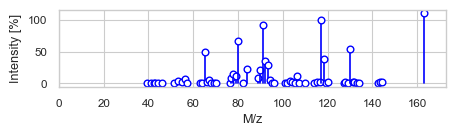

None

MTXSIJUGVMTTMU


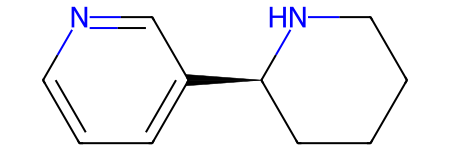

Positive examples


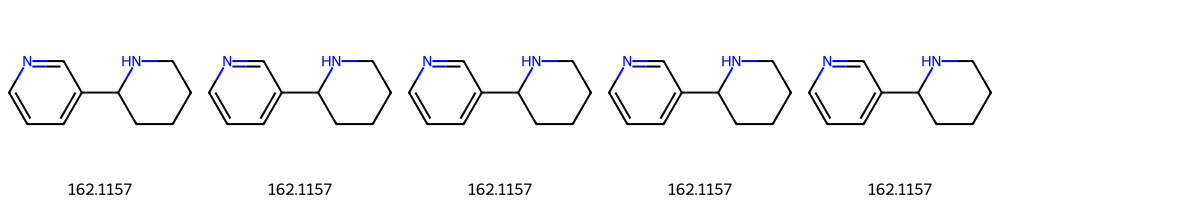

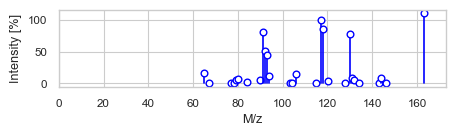

None

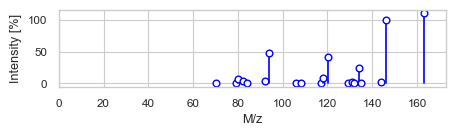

None

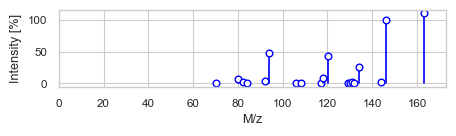

None

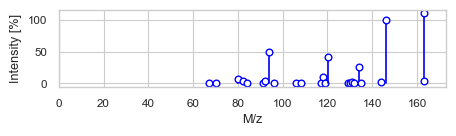

None

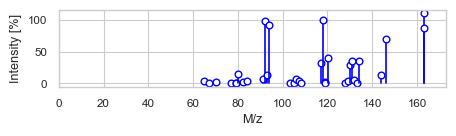

None

Negative examples


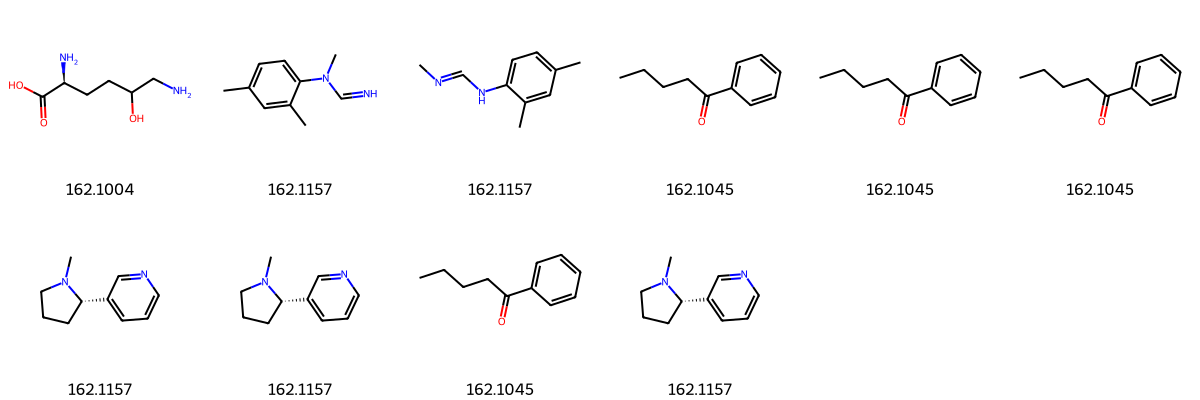

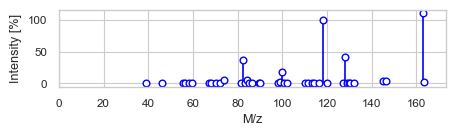

None

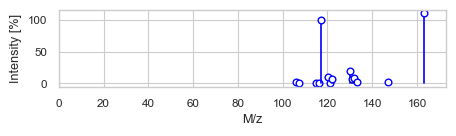

None

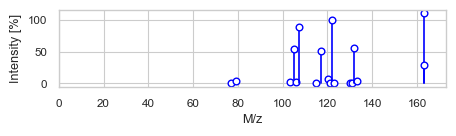

None

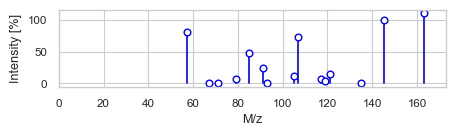

None

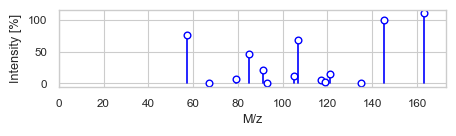

None

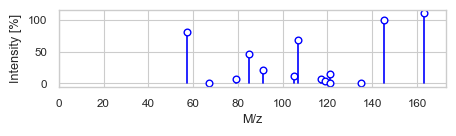

None

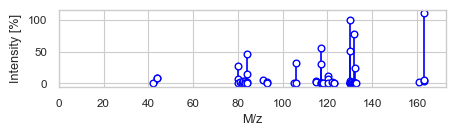

None

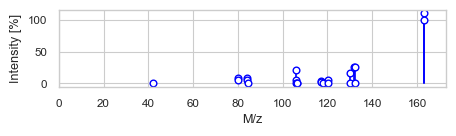

None

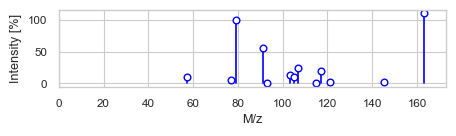

None

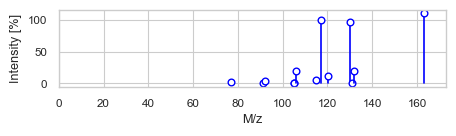

None

--------------------------------------------------------------------------------
733.4612412040001


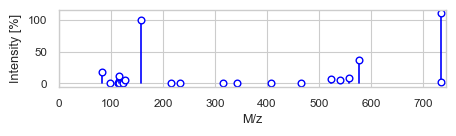

None

ULGZDMOVFRHVEP


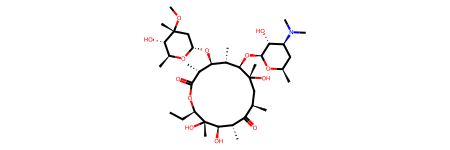

Positive examples


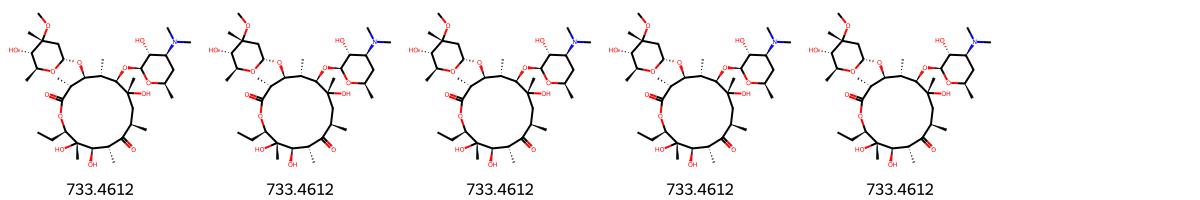

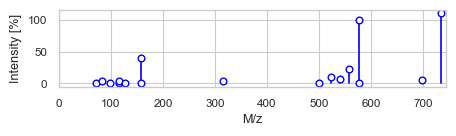

None

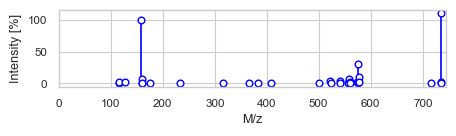

None

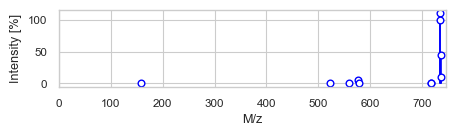

None

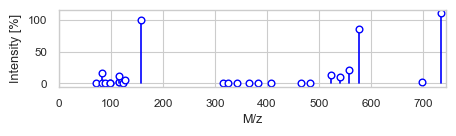

None

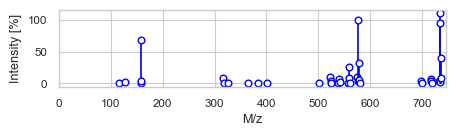

None

Negative examples


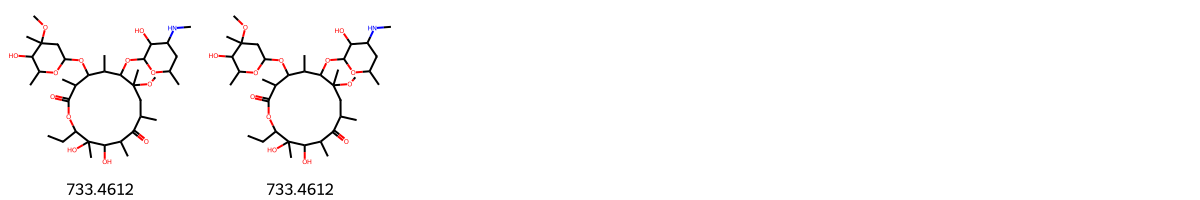

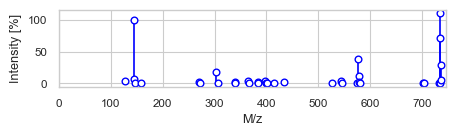

None

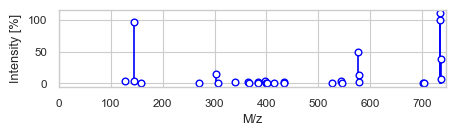

None

ValueError: need at least one array to stack

In [27]:
from dreams.utils.data import ContrastiveSpectraDataset
import dreams.utils.data as du
from dreams.utils.dformats import DataFormatA

dataset = ContrastiveSpectraDataset(df, n_pos_samples=5, n_neg_samples=10, spec_preproc=du.SpectrumPreprocessor(
    dformat=DataFormatA(), prec_intens=1.1, n_highest_peaks=60,
    spec_entropy_cleaning=False
), return_smiles=True)

random.seed(333)
for i in df.index: #random.sample(range(len(dataset)), 3):
    sample = dataset[i]
    print('-' * 80)
    # print(sample['spec'][0, 0])
    print(ExactMolWt(Chem.MolFromSmiles(sample['smiles'])))
    display(su.plot_spectrum(sample['spec'], figsize=(5, 1)))
    print(mu.smiles_to_inchi14(sample['smiles']))
    display(Chem.MolFromSmiles(sample['smiles']))
    print('Positive examples')
    display(mu.show_mols(sample['pos_smiles'], smiles_in=True, legends='masses'))
    for spec in sample['pos_specs']:
        display(su.plot_spectrum(spec, figsize=(5, 1)))
    print('Negative examples')
    display(mu.show_mols(sample['neg_smiles'], smiles_in=True, legends='masses'))#legends=[mu.smiles_to_inchi14(s) for s in sample['neg_smiles']]))
    for spec in sample['neg_specs']:
        display(su.plot_spectrum(spec, figsize=(5, 1)))

In [14]:
# for row_i, row in df.sample(5, random_state=5).iterrows():
#     print('-' * 5, 'Example', row_i, f"({row['PRECURSOR M/Z']} m/z)", '-' * 5)
#     display(row['ROMol'])
#
#     print('Negative examples')
#     rand_neighbours = random.sample(row[f'{mass_tolerance_da} Da neighbours'], 5)
#     display(mu.show_mols([df['ROMol'].loc[i] for i in rand_neighbours], legends=[df['PRECURSOR M/Z'].loc[i] for i in rand_neighbours]))
#
#     print('Positive examples')
#     for i_count, i in enumerate(row['INCHIKEY neighbours']):
#         if i_count > 2:
#             break
#         print(df['PRECURSOR M/Z'].loc[i], 'm/z')
#         su.plot_spectrum(df['PARSED PEAKS'].loc[i])